# Problem set 8
## "The return of ten Arcs"
### Zachary Miller

## Part 1: Generating postive control data
We are suspicious about Lestrade's claim that all ten mRNA transcripts are expressed at the same level. In order to investigate, we want to generate some postive control data under the generative probability model laid out in Li and Dewey (2010) and see how well Lestrade's method performs. Below, we generate an example Arc Locus and then sample 1,000,000 reads from that Arc Locus. One thing to note is that I created to the structure of my simulator to actually generate the segements, and then calculate the read counts for each segement rather than just generating the read counts. I found this method was simpler to debug and ensure that data was actually being generated according to our generative probability model. 

In [1]:
import numpy as np
from scipy.special import logsumexp
import re
import matplotlib.pyplot as plt
import random
import pandas as pd

random.seed(42)
%matplotlib inline

def trans_to_nuc_abunds(trans_abunds_vec, trans_lengths_vec):
    """Given a vector of transcription abundances and a vector of transcript lengths, returns the nucelotide 
    abundances as a list"""
    
    if len(trans_abunds_vec) != len(trans_lengths_vec): return False
    
    num_transcripts = len(trans_abunds_vec)
    nuc_abunds_list = np.multiply(trans_abunds_vec, trans_lengths_vec)
    nuc_abunds_tot = sum(nuc_abunds_list)
    nuc_abunds_list = np.true_divide(nuc_abunds_list, nuc_abunds_tot)
    
    return nuc_abunds_list

def nuc_to_trans_abunds(nuc_abunds_vec, trans_lengths_vec):
    """Given a vector of nucleotide abundances and a vector of transcript lengths, returns the transcript
    abundances as a list"""
    
    if len(nuc_abunds_vec) != len(trans_lengths_vec): return False
    
    num_transcripts = len(nuc_abunds_vec)
    trans_abunds_list = np.true_divide(nuc_abunds_vec, trans_lengths_vec)
    trans_abunds_tot = sum(trans_abunds_list)
    trans_abunds_list = np.true_divide(trans_abunds_list, trans_abunds_tot)
    
    return trans_abunds_list

def generate_rand_abunds_and_lens(trans_num, len_range):
    """Generates a (nearly) uniform random vector of transcript abundances using the dirichlet distribution, and 
    random lengths sampled from the range given by a tuple len_range. Both the transcript abundances and the lengths
    vectors will have a number of elements equal to trans_num"""

    abunds_list = list(np.random.dirichlet(np.ones(trans_num),size=1)[0])
    lens_list = list(np.random.randint(len_range[0], len_range[1]+1, trans_num))
    
    return abunds_list, lens_list

def create_arc(trans_lens_vec):
    """Given a vector of the transcripts lengths, generates a 2d list where the first index represents a 
    transcript, and the second index represents possible reads within that transcript"""
    
    trans_list = []
    num_segs = len(trans_lens_vec)
    seg_list = [i for i in range(num_segs)]
    
    for start_seg, trans_len in enumerate(trans_lens_vec):
        end_seg = start_seg+trans_len
        if end_seg > num_segs:
            transcript = seg_list[start_seg:]+seg_list[:end_seg-num_segs]
            trans_list.append(list(transcript))
            
        else: trans_list.append(seg_list[start_seg:end_seg])
    
    return trans_list

def create_reads(trans_vec, trans_abunds_vec, trans_lens_vec, N):
    """Given a transcriptome trans_vec, samples N reads from that transcriptome according to the nucleotide 
    probabilities given by trans_abunds_vec and trans_lens_vec"""
    
    trans_num = len(trans_vec)
    nuc_abunds_list = trans_to_nuc_abunds(trans_abunds_vec, trans_lens_vec)
    reads_list = []
    for i in range(N):
        transcript_idx = np.random.choice(trans_num,p=nuc_abunds_list)
        transcript = trans_vec[transcript_idx]
        segment = np.random.choice(transcript)
        reads_list.append(segment)
        
    return reads_list

In [2]:
trans_abunds_list, trans_lens_list = generate_rand_abunds_and_lens(10, (2,4))
transcript_list = create_arc(trans_lens_list)
reads_list = create_reads(transcript_list, trans_abunds_list, trans_lens_list, 1000000)

## Part 2: Testing Lestrade's method on the positive control data
Now that we have generated read data for which we know the true transcript abundances and transcript lengths, we can see how well Lestrade's method performs on the read data. In addition to comparing the estimated parameters, we can also calculate the negative log-likelyhood of Lestrade's parameters and see how they compare to the negative log-likeyhood of the true parameters. We know that $P(S,T|\vec{v},\vec{L}) = P(S|T,\vec{L})P(T|\vec{v})$. If we want to find the total probability for a given segment S over all the transcript isofroms T, then we simply marginalize over T to get $P(S,\vec{T}|\vec{v},\vec{L}) = \sum_i P(S|T_i,L_i)P(T_i,v_i)$ (assuming the read maps perfectly to S). Now if we want likelyhood for all of the reads, then we get $$P(\vec{S},\vec{T}|\vec{v},\vec{L}) = \prod_j \sum_i P(S_j|T_i,L_i)P(T_i,v_i) \\=  \prod_j \sum_i \frac{v_i}{L_i} I(S_j \in T_i)$$ where $i$ is the transcript index and $j$ is the segment postition index. Lastly, we will work in logs for this calculation to avoid underflow. Calculating below...

In [3]:
def calc_nll(reads_vec, trans_vec, trans_abunds_vec, trans_lens_vec):
    """Given the necessary parameters, calculates and returns the negative log-likelyhood of the transcript 
    abundances given by trans_abunds_vec"""
    
    nuc_abunds_list = trans_to_nuc_abunds(trans_abunds_vec, trans_lens_vec)
    log_probs_list = []
    unique_reads_arr, unique_read_counts_arr = np.unique(reads_vec, return_counts=True)
    
    # Iterate over each read
    for read_idx, read in enumerate(unique_reads_arr):
        read_prob_list = []
        
        # For each read, iterate over each transcript
        for trans_idx, transcript in enumerate(trans_vec):
            
            # If the transcript contains the read sequence, calculate the probability that the read came from 
            # this transcript and add it to the probability list for this transcript. This implicitly sums 
            # over both S and T, but the if statement means we only get non-zero probabilities
            if read in transcript:
                prob = np.log(nuc_abunds_list[trans_idx]/trans_lens_vec[trans_idx])
                read_prob_list.append(prob)
        
        # Add the total log probability for this unique read
        total_read_log_prob = logsumexp(read_prob_list)*unique_read_counts_arr[read_idx]
        log_probs_list.append(total_read_log_prob)
        
    total_nll = -1*np.sum(log_probs_list)
    
    return total_nll

def get_lestrade_ests(reads_vec, trans_vec, trans_lens_vec):
    """Given the necessary parameters, impliments Lestrade's method and returns his transcript abundance 
    estimates"""
    trans_num = len(trans_lens_vec)
    trans_counts_list = [0]*trans_num
    
    # Iterate over each read
    for read in reads_vec:
        temp_counts = [0]*trans_num
        
        # For each read, add a count for each transcript that include the segment that generated the read
        for idx, transcript in enumerate(trans_vec):
            if read in transcript:
                temp_counts[idx] += 1
                
        # Normalize the counts to add to 1
        temp_tot = sum(temp_counts)
        temp_counts = np.true_divide(temp_counts, temp_tot)
        
        # Add the count proportions for each read to the total counts list
        trans_counts_list = np.add(trans_counts_list, temp_counts)
    
    counts_tot = sum(trans_counts_list)
    est_nuc_abunds_list = np.true_divide(trans_counts_list, counts_tot)
    est_trans_abunds_list = nuc_to_trans_abunds(est_nuc_abunds_list, trans_lens_vec)
    
    return est_trans_abunds_list
        

In [4]:
lestrade_trans_abunds_list = get_lestrade_ests(reads_list, transcript_list, trans_lens_list)
true_nll = calc_nll(reads_list, transcript_list, trans_abunds_list, trans_lens_list)
lestrade_nll = calc_nll(reads_list, transcript_list, lestrade_trans_abunds_list, trans_lens_list)

In [5]:
print("True transcript abundances:")
print(trans_abunds_list)
print("\nLestrade's transcript abundances:")
print(lestrade_trans_abunds_list)
print("\nDifference:")
print(np.abs(np.subtract(trans_abunds_list, lestrade_trans_abunds_list)))

print("\n\nNegative log-likelyhood of true parameters:")
print(true_nll)
print("\nNegative log-likelyhood of Lestrade's parameters:")
print(lestrade_nll)
print("\nNLL difference: ")
print(np.abs(true_nll-lestrade_nll))

True transcript abundances:
[0.13703927728060394, 0.4453969303507804, 0.03958212621058533, 0.03202213339999653, 0.013687791303994364, 0.007895564988538873, 0.10324925675162944, 0.038811351440190406, 0.1592172892529202, 0.023098279020760455]

Lestrade's transcript abundances:
[0.15174964 0.1585744  0.15384128 0.13750741 0.05089204 0.02805102
 0.03723881 0.06424902 0.10614955 0.11174682]

Difference:
[0.01471036 0.28682253 0.11425916 0.10548528 0.03720425 0.02015546
 0.06601045 0.02543767 0.05306773 0.08864855]


Negative log-likelyhood of true parameters:
2061889.6652640572

Negative log-likelyhood of Lestrade's parameters:
2091188.1726446727

NLL difference: 
29298.507380615454


We can see that Lestrade's transcript abundances are quite different from the true transcript abundances. On it's own, this could of course just mean that this is a very hard problem to solve, and Lestrade's estimates are just as good as it is possible to get. However, when we compare the NLL's, we can see that Lestrade's estimates are *far* less likely than the true parameters (keeping in mind that we would exponentiate the NLL difference to get the likelyhood ratio). This tells us that we may be able to get better parameters by optimizing the NLL. To do this, we will use the expectation maximization algorithm. 

## Part 3: Estimating the transcript isofrom abundances with EM
To see if EM can do a better job than Lestrade's method, let's run the EM algorithm on the postive control data and see how it performs.

In [6]:
def read_data_from_file(file_name):
    """TAKEN FROM LESTRADE AND ADAPTED FOR OUR PURPOSES. Reads a data table of the format output by Lestrade and 
    returns the read counts and transcript lengths"""
    with open(file_name) as f:
        #   The first line is "The <n> transcripts of the sand mouse Arc locus"
        line  = f.readline()
        match = re.search(r'^The (\d+) transcripts', line)
        T     = int(match.group(1))

        # The next T lines are 
        #   <Arcn>  <true_tau> <L> <structure>
        # tau's may be present, or obscured ("xxxxx")
        tau       = np.zeros(T)
        L         = np.zeros(T).astype(int)
        tau_known = True   # until we see otherwise
        for i in range(T):
            fields    = f.readline().split()
            if fields[1] == "xxxxx":
                tau_known = False
            else:
                tau[i] = float(fields[1])
            L[i]      = int(fields[2])

        # after a blank line,
        # 'The <n> read sequences':
        line  = f.readline()
        line  = f.readline()
        match = re.search(r'The (\d+) read sequences', line)
        N     = int(match.group(1))

        # the next T lines are 
        #  <read a-j> <count>
        r = np.zeros(T).astype(int)
        for k in range(T):
            fields = f.readline().split()
            r[k]   = fields[1]
            
    read_counts_list = list(r)
    
    return(read_counts_list, L)

def run_EM_optimization(reads_vec, trans_vec, trans_lens_vec, N):
    """"""
    #TODO add a NLL tracker that checks every 100 iterations whether or not it has converged. Plan is to have a
    # max number of iterations that can be shortcut when the NLL is static
    initial_trans_abunds = generate_rand_abunds_and_lens(len(trans_lens_vec), (1,1))[0]
        
    nuc_abunds_list = nuc_to_trans_abunds(initial_trans_abunds, trans_lens_vec)
    trans_num = len(trans_lens_vec)
    unique_reads_arr, unique_read_counts_arr = np.unique(reads_vec, return_counts=True)
    nll_list = [-1]
    
    for iteration in range(N):
        count_arr = np.zeros(10)

        # Iterate over each read
        for read_idx, read in enumerate(unique_reads_arr):
            read_prob_list = []
            idx_list = []
            # For each read, iterate over each transcript
            for trans_idx, transcript in enumerate(trans_vec):
                # If the read is present in the transcript, add its log probability numerator to read_prob_list
                if read in transcript:
                    idx_list.append(trans_idx)
                    numer = np.log(nuc_abunds_list[trans_idx]/trans_lens_vec[trans_idx])
                    read_prob_list.append(numer)

            # Normalize the probabilities by subtracting the log probability of the denominator from each element 
            # of read_prob_list
            denom = logsumexp(read_prob_list)
            read_prob_list = np.subtract(read_prob_list, denom)

            # Add the exponentiated probabilities to the cooresponding transcript count in count_arr
            total_read_counts = np.multiply(np.exp(read_prob_list),unique_read_counts_arr[read_idx])
            np.add.at(count_arr, idx_list, total_read_counts)
            
        # Get nucleotide abunces from counts, then record the corresponding transcript abundances
        new_nuc_abunds = np.divide(count_arr, np.sum(count_arr))
        nuc_abunds_list = new_nuc_abunds
        final_trans_abunds_list = nuc_to_trans_abunds(nuc_abunds_list, trans_lens_vec)

        # Keep track of the NLL every 100 iterations. If the NLL has not changed more that 0.01 in the last 100
        # iterations, stop iterating and report the current transcript abundance estimates
        if iteration%100 == 0:
                nll = calc_nll(reads_vec, trans_vec, final_trans_abunds_list, trans_lens_vec)

                if nll_list[0] == -1:
                    nll_list[0] = nll

                elif np.abs(np.subtract(nll_list[-1], nll)) < 0.01:
                    nll_list.append(nll)
                    print("Number of Iterations: " + str(iteration))
                    return final_trans_abunds_list, nll_list

                else: nll_list.append(nll)

    print("Number of Iterations: " + str(N))
    
    return final_trans_abunds_list, nll_list

            
            

In [7]:
em_est_abunds_arr, em_nll_list = run_EM_optimization(reads_list, transcript_list, trans_lens_list, 5000)

Number of Iterations: 1000


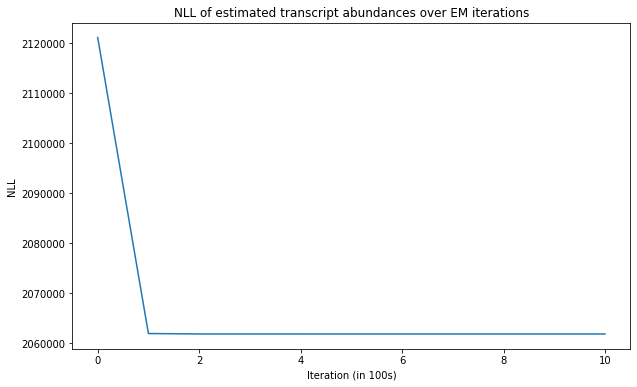

In [8]:
# Plot the NLL over the iterations
plt.figure(figsize=(10,6))
plt.plot(em_nll_list)
plt.xlabel("Iteration (in 100s)")
plt.ylabel("NLL")
plt.title("NLL of estimated transcript abundances over EM iterations")
plt.show()

In [9]:
print("True transcript abundances:")
print(trans_abunds_list)
print("\nEM transcript abundances:")
print(list(em_est_abunds_arr))
print("\nDifference:")
print(np.abs(np.subtract(trans_abunds_list, em_est_abunds_arr)))

print("\n\nNegative log-likelyhood of true parameters:")
print(true_nll)
print("\nNegative log-likelyhood EM parameters:")
print(em_nll_list[-1])
print("\nNLL difference: ")
print(np.abs(true_nll-em_nll_list[-1]))

True transcript abundances:
[0.13703927728060394, 0.4453969303507804, 0.03958212621058533, 0.03202213339999653, 0.013687791303994364, 0.007895564988538873, 0.10324925675162944, 0.038811351440190406, 0.1592172892529202, 0.023098279020760455]

EM transcript abundances:
[0.13660421722228583, 0.4469908600644412, 0.03661646350730236, 0.033659474748151764, 0.012440549178221188, 0.009006253315964859, 0.10354763403615472, 0.03858866574309242, 0.1595251335819148, 0.023020748602470754]

Difference:
[4.35060058e-04 1.59392971e-03 2.96566270e-03 1.63734135e-03
 1.24724213e-03 1.11068833e-03 2.98377285e-04 2.22685697e-04
 3.07844329e-04 7.75304183e-05]


Negative log-likelyhood of true parameters:
2061889.6652640572

Negative log-likelyhood EM parameters:
2061888.0727601387

NLL difference: 
1.5925039185676724


As you can see above, EM clearly performs much better than Letsrade's method, both is the accuracy of its parameter estimates and in the NLL of its parameter estimates. This is also good evidence that our generative probability model is a fairly good one, since closer parameter values also produced closer NLL values. 

Now that we are confident that our EM algorithm works, let's test EM on that actual data that Lestrade was trying to get transcript isofrom abundances for.

In [10]:
# Gather the parameters needed for EM optimization of the actual data
read_counts_list, trans_lens_list = read_data_from_file("w08-data.out")
reads_list = []

for read_idx, read_count in enumerate(read_counts_list):
    reads_list += [read_idx]*read_count
    
arc_transcript_list = create_arc(trans_lens_list)

# Run the EM optimization
my_est_abunds_arr, nll_list = run_EM_optimization(reads_list, arc_transcript_list, trans_lens_list, 5000)

Number of Iterations: 1600


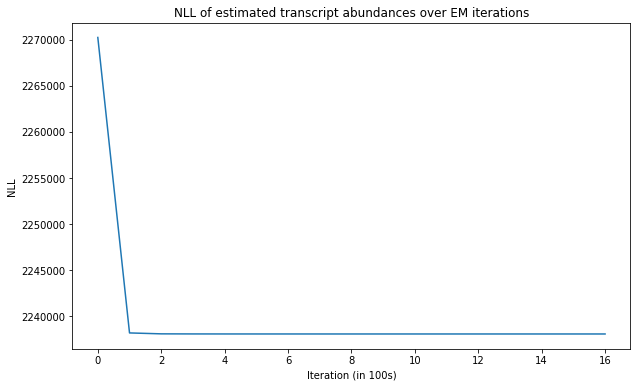

In [11]:
# Plot the NLL over the iterations
plt.figure(figsize=(10,6))
plt.plot(nll_list)
plt.xlabel("Iteration (in 100s)")
plt.ylabel("NLL")
plt.title("NLL of estimated transcript abundances over EM iterations")
plt.show()

In [12]:
lestrade_est_abunds_list = get_lestrade_ests(reads_list, arc_transcript_list, trans_lens_list)
my_nll = calc_nll(reads_list, arc_transcript_list, my_est_abunds_arr, trans_lens_list)
lestrade_nll = calc_nll(reads_list, arc_transcript_list, lestrade_est_abunds_list, trans_lens_list)
print("My estimated transcript abundances:")
print(list(my_est_abunds_arr))
print("\nLestrade's estimated transcript abundances:")
print(lestrade_est_abunds_list)
print("\nDifference:")
print(np.abs(np.subtract(my_est_abunds_arr, lestrade_est_abunds_list)))

print("\n\nNegative log-likelyhood of my parameters:")
print(my_nll)
print("\nNegative log-likelyhood of Lestrade's parameters:")
print(lestrade_nll)
print("\nNLL difference: ")
print(np.abs(my_nll-lestrade_nll))

My estimated transcript abundances:
[0.05255061827185243, 0.09783664085955299, 0.06298480982962416, 0.11650982305357578, 0.04397523035489666, 0.3024092631691933, 0.0023079764120179157, 0.07361977833843916, 0.061161359798388534, 0.186644499912459]

Lestrade's estimated transcript abundances:
[0.0896395  0.09112976 0.07383159 0.10491783 0.11192892 0.12457224
 0.11018329 0.08591525 0.09649783 0.11138378]

Difference:
[0.03708889 0.00670688 0.01084678 0.01159199 0.06795369 0.17783703
 0.10787531 0.01229547 0.03533647 0.07526072]


Negative log-likelyhood of my parameters:
2238099.539384689

Negative log-likelyhood of Lestrade's parameters:
2253910.9353717305

NLL difference: 
15811.395987041295


In [13]:
# Display our final Arc abundance estimates
names_list = ["Arc"+str(i+1) for i in range(len(trans_lens_list))]
data = {"Arc":names_list, "Est. Abundance":list(my_est_abunds_arr)}
df = pd.DataFrame(data)
print(df)

sorted_trans_abunds_list = my_est_abunds_arr
sorted_trans_abunds_list = np.sort(sorted_trans_abunds_list)
max_2_trans = [np.where(my_est_abunds_arr == sorted_trans_abunds_list[-2])[0][0]+1, 
               np.where(my_est_abunds_arr == sorted_trans_abunds_list[-1])[0][0]+1]
min_2_trans = [np.where(my_est_abunds_arr == sorted_trans_abunds_list[0])[0][0]+1, 
               np.where(my_est_abunds_arr == sorted_trans_abunds_list[1])[0][0]+1]

print("Most expressed 2 arcs: " + str(max_2_trans) + " make up " + 
      str(sorted_trans_abunds_list[-2] + sorted_trans_abunds_list[-1]) + " percent of transcripts")

print("Least expressed 2 arcs: " + str(min_2_trans) + " make up " + 
      str(sorted_trans_abunds_list[0] + sorted_trans_abunds_list[1]) + " percent of transcripts")

     Arc  Est. Abundance
0   Arc1        0.052551
1   Arc2        0.097837
2   Arc3        0.062985
3   Arc4        0.116510
4   Arc5        0.043975
5   Arc6        0.302409
6   Arc7        0.002308
7   Arc8        0.073620
8   Arc9        0.061161
9  Arc10        0.186644
Most expressed 2 arcs: [10, 6] make up 0.48905376308165227 percent of transcripts
Least expressed 2 arcs: [7, 5] make up 0.046283206766914574 percent of transcripts


As expected, we see that our trascript isoform abundance estimates are quite different from Lestrade's, and also much more likely. It is also quite clear that the transcript isofrom abundances are not nearly uniform, as Lestrade claims. For example, from our estimates it appears that Arc6 is expressed at a rate about 150 times higher than Arc7. Therefore, we find that Lestrade's conlcusions are incorrect. Arc6 and Arc10 are the most abundant transcripts, accounting for amost half of all transcriptions, while Arc5 and Arc7 are the smallest two transcripts, making up less than 5% of all transcriptions.